In [3]:
#!/usr/bin/env python3
"""
iTransformer Autoencoder for STEAD Noise
Unsupervised anomaly detection (noise-only training)

Comparable with:
- LSTM AE
- 1D-CNN AE
"""

import os
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, MultiHeadAttention, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split


# ============================================================
# CONFIGURATION
# ============================================================
DATA_PATH = "/content/drive/MyDrive/anomaly_selin/Data/df_noise_train.pkl"

LOOKBACK = 128
STRIDE = 64
BATCH_SIZE = 256
EPOCHS = 50

MAX_TRACES = 4000
MAX_WINDOWS_PER_TRACE = 100
RANDOM_SEED = 42

D_MODEL = 64
N_HEADS = 4
N_LAYERS = 2
DROPOUT = 0.1

MODEL_DIR = "/content/drive/MyDrive/anomaly_selin/models/itransformer"
os.makedirs(MODEL_DIR, exist_ok=True)


# ============================================================
# LOAD DATA
# ============================================================
print("🔹 Loading STEAD noise data...")
df = pd.read_pickle(DATA_PATH)
df = df.sample(n=MAX_TRACES, random_state=RANDOM_SEED).reset_index(drop=True)
print(f"Loaded {len(df)} noise traces")


# ============================================================
# WINDOWING
# ============================================================
def make_windows(signal, win=128, stride=64):
    windows = []
    for i in range(0, len(signal) - win, stride):
        windows.append(signal[i:i + win])
    return np.array(windows, dtype=np.float32)


print("\n🔹 Building training windows...")
X_all = []

for z in df["Z_channel"]:
    z = np.asarray(z, dtype=np.float32)
    z = (z - z.mean()) / (z.std() + 1e-6)

    windows = make_windows(z, LOOKBACK, STRIDE)

    if len(windows) > MAX_WINDOWS_PER_TRACE:
        idx = np.random.choice(len(windows), MAX_WINDOWS_PER_TRACE, replace=False)
        windows = windows[idx]

    X_all.append(windows)

X = np.vstack(X_all)[..., np.newaxis]

print("Total windows:", X.shape)


# ============================================================
# TRAIN / VAL SPLIT
# ============================================================
X_train, X_val = train_test_split(
    X, test_size=0.2, random_state=RANDOM_SEED, shuffle=True
)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)


# ============================================================
# TRANSFORMER BLOCK
# ============================================================
def transformer_block(x):
    attn = MultiHeadAttention(
        num_heads=N_HEADS,
        key_dim=D_MODEL // N_HEADS,
        dropout=DROPOUT
    )(x, x)
    x = LayerNormalization()(x + attn)

    ff = Dense(D_MODEL * 4, activation="relu")(x)
    ff = Dense(D_MODEL)(ff)
    x = LayerNormalization()(x + ff)

    return x


# ============================================================
# iTRANSFORMER AUTOENCODER
# ============================================================
print("\n🔹 Building iTransformer Autoencoder...")

inp = Input(shape=(LOOKBACK, 1))

# Inverted embedding (time as tokens)
x = Dense(D_MODEL)(inp)

# Encoder
for _ in range(N_LAYERS):
    x = transformer_block(x)

# Bottleneck
latent = Dense(D_MODEL, activation="relu")(x)

# Decoder
x = latent
for _ in range(N_LAYERS):
    x = transformer_block(x)

out = Dense(1)(x)

model = Model(inp, out)
model.compile(optimizer="adam", loss="mse")

model.summary()


# ============================================================
# CALLBACKS
# ============================================================
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "itransformer_ae_best.keras"),
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)


# ============================================================
# TRAIN
# ============================================================
print("\n🚀 Training iTransformer Autoencoder...")

history = model.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[early_stop, checkpoint]
)


# ============================================================
# SAVE FINAL MODEL
# ============================================================
final_path = os.path.join(MODEL_DIR, "itransformer_ae_final.keras")
model.save(final_path)

print("\n✅ Training complete")
print(f"Best model : {MODEL_DIR}/itransformer_ae_best.keras")
print(f"Final model: {final_path}")


🔹 Loading STEAD noise data...
Loaded 4000 noise traces

🔹 Building training windows...
Total windows: (368000, 128, 1)
Train: (294400, 128, 1)
Val  : (73600, 128, 1)

🔹 Building iTransformer Autoencoder...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128, 64)   │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 64)   │     16,640 │ dense[0][0],      │
│ (MultiHeadAttentio… │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 64)   │          0 │ dense[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128, 256)  │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128, 64)   │     16,448 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128, 256)  │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128, 64)   │     16,448 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 64)   │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 64)   │     16,640 │ dense_5[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 128, 64)   │          0 │ dense_5[0][0],  

 Total params: 204,289 (798.00 KB)

 Trainable params: 204,289 (798.00 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Training iTransformer Autoencoder...
Epoch 1/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2333
Epoch 1: val_loss improved from inf to 0.00199, saving model to /content/drive/MyDrive/anomaly_selin/models/itransformer/itransformer_ae_best.keras
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 90s 62ms/step - loss: 0.2332 - val_loss: 0.0020
Epoch 2/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0021
Epoch 2: val_loss improved from 0.00199 to 0.00190, saving model to /content/drive/MyDrive/anomaly_selin/models/itransformer/itransformer_ae_best.keras
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 70s 61ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 3/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0019
Epoch 3: val_loss improved from 0.00190 to 0.00122, saving model to /content/drive/MyDrive/anomaly_selin/models/itransformer/itransformer_ae_best.keras
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 70s 61ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 4/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss

🔹 Loading trained iTransformer Autoencoder...
✅ Model loaded

🔹 Loading custom window-level test dataset...
✅ Loaded
X shape: (54324, 128, 1)
y shape: (54324,)
Noise windows: 24681
EQ windows   : 29643

🔹 Running reconstruction...


I0000 00:00:1767889743.155893 8910605 service.cc:148] XLA service 0x329b0c0a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767889743.155924 8910605 service.cc:156]   StreamExecutor device (0): Host, Default Version
2026-01-08 19:29:03.189982: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/213 ━━━━━━━━━━━━━━━━━━━━ 2:22 673ms/step

I0000 00:00:1767889743.452936 8910605 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


213/213 ━━━━━━━━━━━━━━━━━━━━ 35s 162ms/step

📊 ERROR STATISTICS
------------------------------------------------------------
Mean   : 4.348916627350263e-05
Median : 2.121524630638305e-06
Std    : 0.0005573258968070149

📊 ROC AUC (iTransformer)
------------------------------------------------------------
AUC : 0.8181


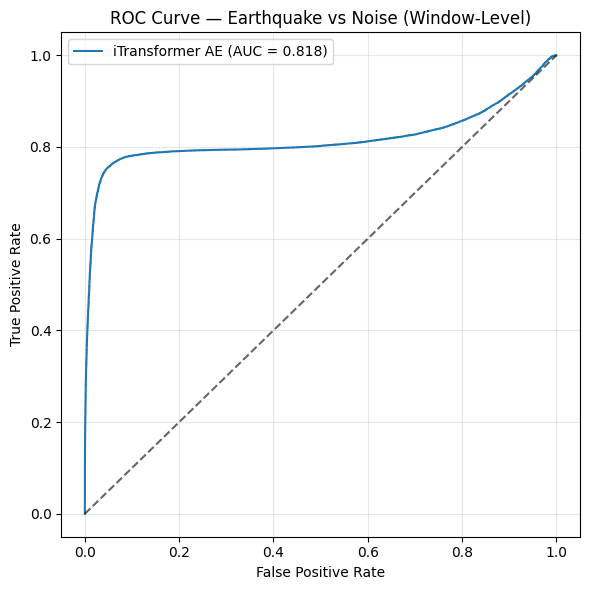

In [3]:
#!/usr/bin/env python3
"""
iTransformer Autoencoder — Window-Level Evaluation
Earthquake vs Noise using saved custom test dataset
"""

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# ============================================================
# PATHS
# ============================================================
MODEL_PATH = "/Users/selinbardakci/BitirmeProjesi/iTransformer/itransformer_ae_best.keras"
TEST_NPZ   = "/Users/selinbardakci/BitirmeProjesi/data/custom_window_test.npz"


# ============================================================
# LOAD MODEL
# ============================================================
print("🔹 Loading trained iTransformer Autoencoder...")
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded")


# ============================================================
# LOAD CUSTOM TEST DATASET
# ============================================================
print("\n🔹 Loading custom window-level test dataset...")
data = np.load(TEST_NPZ)

X = data["X"]   # (N, 128, 1)
y = data["y"]   # (N,)

print("✅ Loaded")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Noise windows:", (y == 0).sum())
print("EQ windows   :", (y == 1).sum())


# ============================================================
# RECONSTRUCTION ERROR
# ============================================================
print("\n🔹 Running reconstruction...")
X_hat = model.predict(X, batch_size=256, verbose=1)

errors = np.mean((X - X_hat) ** 2, axis=(1, 2))

print("\n📊 ERROR STATISTICS")
print("------------------------------------------------------------")
print("Mean   :", float(errors.mean()))
print("Median :", float(np.median(errors)))
print("Std    :", float(errors.std()))


# ============================================================
# ROC + AUC
# ============================================================
fpr, tpr, thresholds = roc_curve(y, errors)
roc_auc = auc(fpr, tpr)

print("\n📊 ROC AUC (iTransformer)")
print("------------------------------------------------------------")
print(f"AUC : {roc_auc:.4f}")


# ============================================================
# PLOT ROC CURVE
# ============================================================
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"iTransformer AE (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Earthquake vs Noise (Window-Level)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


🔹 Loading trained iTransformer Autoencoder...
✅ Model loaded

🔹 Loading test dataset...
✅ Dataset loaded
   Total windows: 54324
   Noise windows: 24681
   EQ windows: 29643

🔹 Computing reconstruction errors...
✅ Reconstruction complete
   Mean error: 0.000043
   Std error: 0.000557

🔹 Computing ROC curve...
✅ ROC AUC: 0.8181

🎯 OPTIMAL THRESHOLD SELECTION

1️⃣  YOUDEN'S J STATISTIC (TPR - FPR)
   Optimal threshold: 0.00000230
   TPR: 0.754
   FPR: 0.047
   J-score: 0.707

2️⃣  CLOSEST TO TOP-LEFT CORNER (0,1)
   Optimal threshold: 0.00000217
   TPR: 0.777
   FPR: 0.083
   Distance: 0.238

3️⃣  F1-SCORE MAXIMIZATION
   Optimal threshold: 0.00000224
   TPR: 0.764
   FPR: 0.058
   F1-Score: 0.838

📊 PERFORMANCE WITH YOUDEN'S OPTIMAL THRESHOLD

   Threshold: 0.00000230

   Confusion Matrix:
   ┌─────────────┬──────────┬──────────┐
   │             │ Pred: 0  │ Pred: 1  │
   ├─────────────┼──────────┼──────────┤
   │ True: 0     │    23512 │     1169 │
   │ True: 1     │     7294 │    223

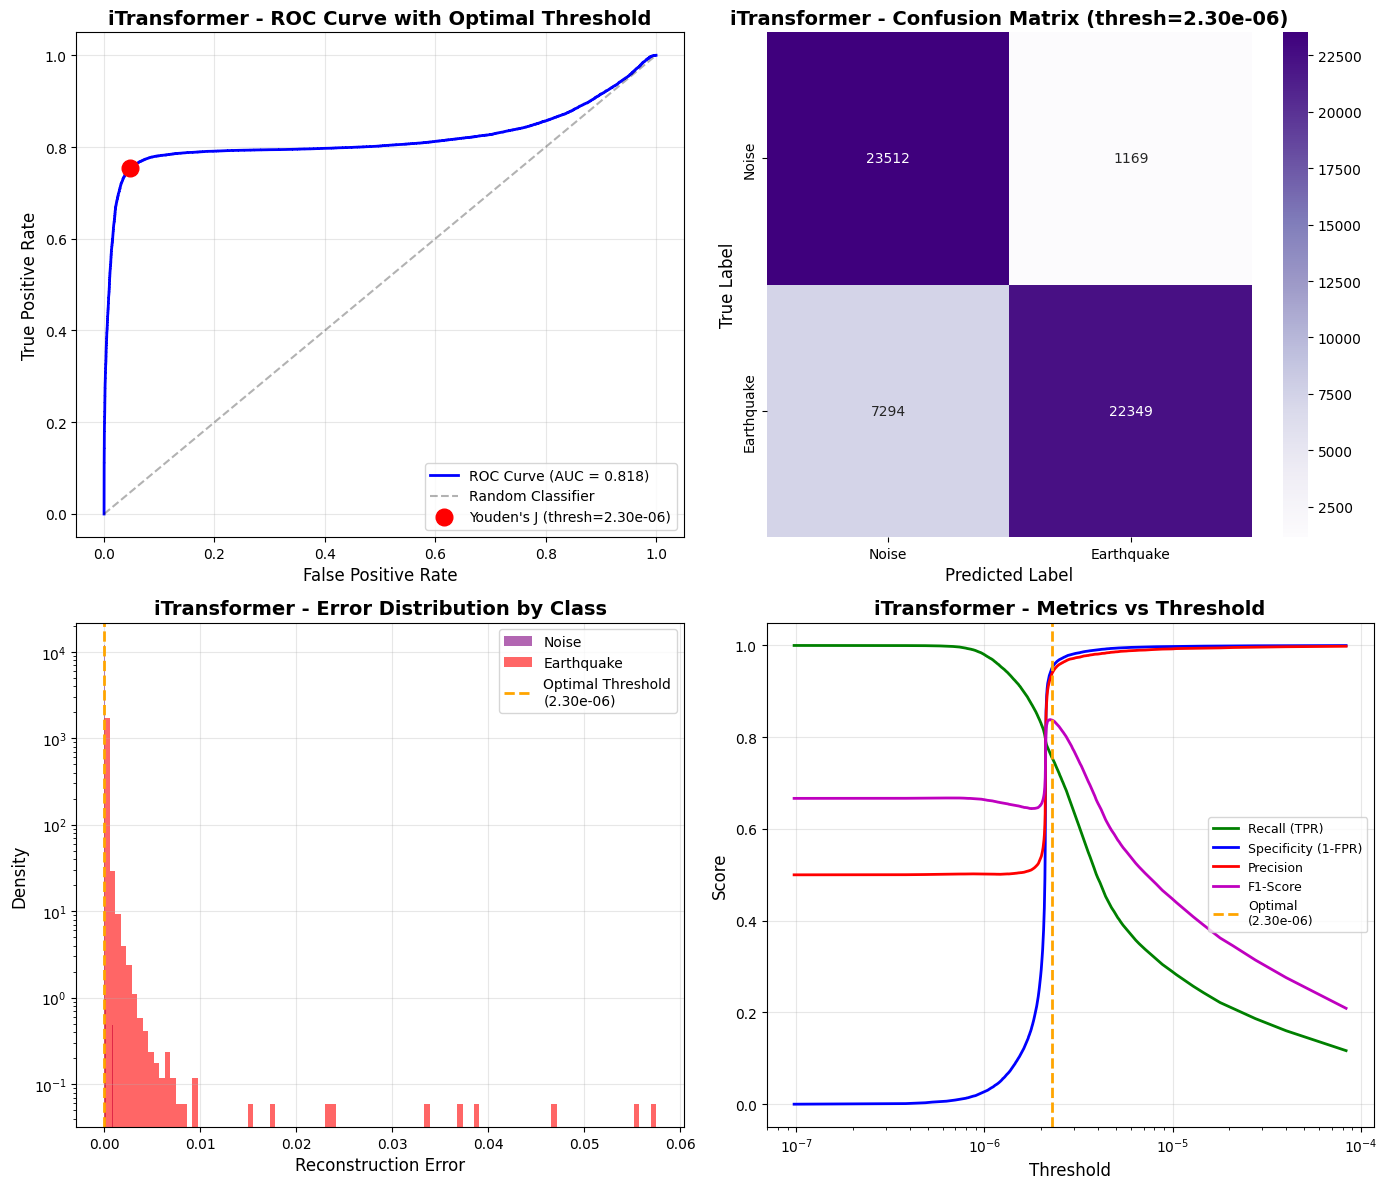


📈 THRESHOLD COMPARISON TABLE

Method          Threshold    Recall   Precision  F1       Accuracy
----------------------------------------------------------------------
p90             0.000002     0.781    0.904      0.838    0.835   
p95             0.000002     0.756    0.948      0.841    0.844   
p97             0.000003     0.716    0.966      0.823    0.832   
p99             0.000004     0.512    0.984      0.673    0.729   
Youden          0.000002     0.754    0.950      0.841    0.844   
Corner          0.000002     0.777    0.919      0.842    0.841   
F1-Max          0.000002     0.764    0.940      0.843    0.845   
✅ iTransformer ROC-based threshold analysis complete!


In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# =========================
# PATHS
# =========================
MODEL_PATH = "./itransformer_ae_best.keras"
TEST_NPZ   = "/Users/selinbardakci/BitirmeProjesi/data/custom_window_test.npz"

# =========================
# LOAD MODEL
# =========================
print("🔹 Loading trained iTransformer Autoencoder...")
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded\n")

# =========================
# LOAD TEST DATA
# =========================
print("🔹 Loading test dataset...")
data = np.load(TEST_NPZ)
X = data["X"]   # (N, 128, 1)
y = data["y"]   # (N,)

print(f"✅ Dataset loaded")
print(f"   Total windows: {len(X)}")
print(f"   Noise windows: {(y==0).sum()}")
print(f"   EQ windows: {(y==1).sum()}\n")

# =========================
# COMPUTE RECONSTRUCTION ERROR
# =========================
print("🔹 Computing reconstruction errors...")
X_hat = model.predict(X, batch_size=256, verbose=0)
errors = np.mean((X - X_hat) ** 2, axis=(1, 2))

print(f"✅ Reconstruction complete")
print(f"   Mean error: {errors.mean():.6f}")
print(f"   Std error: {errors.std():.6f}\n")

# =========================
# ROC CURVE
# =========================
print("🔹 Computing ROC curve...")
fpr, tpr, thresholds = roc_curve(y, errors)
roc_auc = auc(fpr, tpr)

print(f"✅ ROC AUC: {roc_auc:.4f}\n")

# =========================
# OPTIMAL THRESHOLD METHODS
# =========================
print("="*70)
print("🎯 OPTIMAL THRESHOLD SELECTION")
print("="*70)

# Method 1: Youden's J statistic (maximize TPR - FPR)
j_scores = tpr - fpr
optimal_idx_youden = np.argmax(j_scores)
optimal_threshold_youden = thresholds[optimal_idx_youden]

print(f"\n1️⃣  YOUDEN'S J STATISTIC (TPR - FPR)")
print(f"   Optimal threshold: {optimal_threshold_youden:.8f}")
print(f"   TPR: {tpr[optimal_idx_youden]:.3f}")
print(f"   FPR: {fpr[optimal_idx_youden]:.3f}")
print(f"   J-score: {j_scores[optimal_idx_youden]:.3f}")

# Method 2: Closest to top-left corner (0,1)
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
optimal_idx_corner = np.argmin(distances)
optimal_threshold_corner = thresholds[optimal_idx_corner]

print(f"\n2️⃣  CLOSEST TO TOP-LEFT CORNER (0,1)")
print(f"   Optimal threshold: {optimal_threshold_corner:.8f}")
print(f"   TPR: {tpr[optimal_idx_corner]:.3f}")
print(f"   FPR: {fpr[optimal_idx_corner]:.3f}")
print(f"   Distance: {distances[optimal_idx_corner]:.3f}")

# Method 3: F1-Score maximization
precisions = tpr / (tpr + fpr + 1e-10)
f1_scores = 2 * (precisions * tpr) / (precisions + tpr + 1e-10)
optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds[optimal_idx_f1]

print(f"\n3️⃣  F1-SCORE MAXIMIZATION")
print(f"   Optimal threshold: {optimal_threshold_f1:.8f}")
print(f"   TPR: {tpr[optimal_idx_f1]:.3f}")
print(f"   FPR: {fpr[optimal_idx_f1]:.3f}")
print(f"   F1-Score: {f1_scores[optimal_idx_f1]:.3f}")

# =========================
# EVALUATE WITH YOUDEN'S THRESHOLD (RECOMMENDED)
# =========================
OPTIMAL_THRESHOLD = optimal_threshold_youden
y_pred = (errors > OPTIMAL_THRESHOLD).astype(int)

cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp + 1e-9)
recall = tp / (tp + fn + 1e-9)
f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
specificity = tn / (tn + fp + 1e-9)

print("\n" + "="*70)
print("📊 PERFORMANCE WITH YOUDEN'S OPTIMAL THRESHOLD")
print("="*70)
print(f"\n   Threshold: {OPTIMAL_THRESHOLD:.8f}")
print(f"\n   Confusion Matrix:")
print(f"   ┌─────────────┬──────────┬──────────┐")
print(f"   │             │ Pred: 0  │ Pred: 1  │")
print(f"   ├─────────────┼──────────┼──────────┤")
print(f"   │ True: 0     │ {tn:8d} │ {fp:8d} │")
print(f"   │ True: 1     │ {fn:8d} │ {tp:8d} │")
print(f"   └─────────────┴──────────┴──────────┘")
print(f"\n   Metrics:")
print(f"   • Accuracy:    {accuracy:.3f}")
print(f"   • Precision:   {precision:.3f}")
print(f"   • Recall:      {recall:.3f}")
print(f"   • F1-Score:    {f1:.3f}")
print(f"   • Specificity: {specificity:.3f}")
print(f"   • ROC AUC:     {roc_auc:.3f}")

# =========================
# VISUALIZATIONS
# =========================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. ROC Curve with optimal point
ax1 = axes[0, 0]
ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random Classifier')
ax1.plot(fpr[optimal_idx_youden], tpr[optimal_idx_youden], 'ro', 
         markersize=12, label=f"Youden's J (thresh={optimal_threshold_youden:.2e})")
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('iTransformer - ROC Curve with Optimal Threshold', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# 2. Confusion Matrix Heatmap
ax2 = axes[0, 1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True, ax=ax2,
            xticklabels=['Noise', 'Earthquake'],
            yticklabels=['Noise', 'Earthquake'])
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_title(f'iTransformer - Confusion Matrix (thresh={OPTIMAL_THRESHOLD:.2e})', 
              fontsize=14, fontweight='bold')

# 3. Error Distribution with Threshold
ax3 = axes[1, 0]
noise_errors = errors[y == 0]
eq_errors = errors[y == 1]

ax3.hist(noise_errors, bins=100, alpha=0.6, color='purple', label='Noise', density=True)
ax3.hist(eq_errors, bins=100, alpha=0.6, color='red', label='Earthquake', density=True)
ax3.axvline(OPTIMAL_THRESHOLD, color='orange', linestyle='--', linewidth=2, 
            label=f'Optimal Threshold\n({OPTIMAL_THRESHOLD:.2e})')
ax3.set_xlabel('Reconstruction Error', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('iTransformer - Error Distribution by Class', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.set_yscale('log')

# 4. Metrics vs Threshold
ax4 = axes[1, 1]
sample_indices = np.linspace(0, len(thresholds)-1, 1000, dtype=int)
ax4.plot(thresholds[sample_indices], tpr[sample_indices], 'g-', label='Recall (TPR)', linewidth=2)
ax4.plot(thresholds[sample_indices], 1-fpr[sample_indices], 'b-', label='Specificity (1-FPR)', linewidth=2)
ax4.plot(thresholds[sample_indices], precisions[sample_indices], 'r-', label='Precision', linewidth=2)
ax4.plot(thresholds[sample_indices], f1_scores[sample_indices], 'm-', label='F1-Score', linewidth=2)
ax4.axvline(OPTIMAL_THRESHOLD, color='orange', linestyle='--', linewidth=2, 
            label=f'Optimal\n({OPTIMAL_THRESHOLD:.2e})')
ax4.set_xlabel('Threshold', fontsize=12)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('iTransformer - Metrics vs Threshold', fontsize=14, fontweight='bold')
ax4.set_xscale('log')
ax4.legend(loc='best', fontsize=9)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# =========================
# COMPARISON TABLE
# =========================
print("\n" + "="*70)
print("📈 THRESHOLD COMPARISON TABLE")
print("="*70)

comparison_thresholds = {
    "p90": np.percentile(noise_errors, 90),
    "p95": np.percentile(noise_errors, 95),
    "p97": np.percentile(noise_errors, 97),
    "p99": np.percentile(noise_errors, 99),
    "Youden": optimal_threshold_youden,
    "Corner": optimal_threshold_corner,
    "F1-Max": optimal_threshold_f1
}

print(f"\n{'Method':<15} {'Threshold':<12} {'Recall':<8} {'Precision':<10} {'F1':<8} {'Accuracy':<8}")
print("-" * 70)

for name, thresh in comparison_thresholds.items():
    y_p = (errors > thresh).astype(int)
    cm_temp = confusion_matrix(y, y_p)
    tn_t, fp_t, fn_t, tp_t = cm_temp.ravel()
    
    acc = (tp_t + tn_t) / (tp_t + tn_t + fp_t + fn_t)
    prec = tp_t / (tp_t + fp_t + 1e-9)
    rec = tp_t / (tp_t + fn_t + 1e-9)
    f1_t = 2 * (prec * rec) / (prec + rec + 1e-9)
    
    print(f"{name:<15} {thresh:<12.6f} {rec:<8.3f} {prec:<10.3f} {f1_t:<8.3f} {acc:<8.3f}")

print("="*70)
print("✅ iTransformer ROC-based threshold analysis complete!")
print("="*70)

In [5]:
from sklearn.metrics import precision_recall_curve, matthews_corrcoef, confusion_matrix
import numpy as np

print("\n🔧 Adding advanced thresholding methods (NumPy-only)...\n")

advanced_thresholds = {}

# ============================================================
# 0) BASIC NOISE SUBSET
# ============================================================
noise_errors = errors[y == 0]


# ============================================================
# 1) PR-F1 MAX THRESHOLD
# ============================================================
precisions_pr, recalls_pr, th_pr = precision_recall_curve(y, errors)
f1_pr = 2 * (precisions_pr * recalls_pr) / (precisions_pr + recalls_pr + 1e-9)
idx_f1_pr = np.argmax(f1_pr)
th_pr_f1 = th_pr[idx_f1_pr]
advanced_thresholds["PR-F1-Max"] = th_pr_f1


# ============================================================
# 2) MCC-MAX THRESHOLD
# ============================================================
best_mcc = -1
best_th_mcc = None

for th in thresholds:
    y_pred = (errors > th).astype(int)
    mcc = matthews_corrcoef(y, y_pred)
    if mcc > best_mcc:
        best_mcc = mcc
        best_th_mcc = th

advanced_thresholds["MCC-Max"] = best_th_mcc


# ============================================================
# 3) G-MEAN MAX THRESHOLD
# ============================================================
gmean = np.sqrt(tpr * (1 - fpr))
idx_gmean = np.argmax(gmean)
th_gmean = thresholds[idx_gmean]
advanced_thresholds["G-Mean-Max"] = th_gmean


# ============================================================
# 4) PRECISION ≥ 0.95 Threshold (maximize recall)
# ============================================================
best_rec = -1
best_th_prec95 = None

for th in thresholds:
    y_pred = (errors > th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    precision_curr = tp / (tp + fp + 1e-9)
    recall_curr = tp / (tp + fn + 1e-9)

    if precision_curr >= 0.95 and recall_curr > best_rec:
        best_rec = recall_curr
        best_th_prec95 = th

advanced_thresholds["Prec≥0.95"] = best_th_prec95


# ============================================================
# 5) k-SIGMA THRESHOLD (Noise-only)
# ============================================================
mu = noise_errors.mean()
sigma = noise_errors.std()
k = 4.0   # changeable
th_ksigma = mu + k * sigma
advanced_thresholds["kSigma(k=4)"] = th_ksigma


# ============================================================
# 6) MAD THRESHOLD (Noise-only)
# ============================================================
median = np.median(noise_errors)
mad = np.median(np.abs(noise_errors - median))
k_mad = 6.0
th_mad = median + k_mad * mad
advanced_thresholds["MAD(k=6)"] = th_mad


# ============================================================
# 7) NUMPY-ONLY KMEANS (2 clusters)
# ============================================================
def kmeans_1d_threshold(errors, max_iter=100):
    e = errors.reshape(-1, 1).astype(float)

    # initialize cluster centers at min and max
    c1 = np.min(e)
    c2 = np.max(e)

    for _ in range(max_iter):
        # assign clusters
        labels = np.where(np.abs(e - c1) < np.abs(e - c2), 0, 1)

        new_c1 = np.mean(e[labels == 0])
        new_c2 = np.mean(e[labels == 1])

        # break on convergence
        if np.isclose(c1, new_c1) and np.isclose(c2, new_c2):
            break

        c1, c2 = new_c1, new_c2

    centers = np.sort([c1, c2])
    return (centers[0] + centers[1]) / 2.0

th_kmeans = kmeans_1d_threshold(errors)
advanced_thresholds["KMeans"] = th_kmeans


# ============================================================
# 8) NUMPY-ONLY OTSU THRESHOLD
# ============================================================
def otsu_threshold(errs):
    errs = np.sort(errs)
    hist, bin_edges = np.histogram(errs, bins=256)
    hist = hist.astype(float)

    # normalized histogram
    p = hist / np.sum(hist)
    omega = np.cumsum(p)
    mu = np.cumsum(p * np.arange(256))
    mu_t = mu[-1]

    sigma_b = (mu_t * omega - mu)**2 / (omega * (1 - omega) + 1e-9)
    idx = np.argmax(sigma_b)
    return bin_edges[idx]

th_otsu = otsu_threshold(errors)
advanced_thresholds["Otsu"] = th_otsu


# ============================================================
# MERGE WITH ORIGINAL TABLE
# ============================================================
comparison_thresholds.update(advanced_thresholds)


# ============================================================
# PRINT EXTENDED TABLE
# ============================================================
print("\n" + "="*70)
print("📈 EXTENDED THRESHOLD COMPARISON TABLE")
print("="*70)
print(f"\n{'Method':<15} {'Threshold':<12} {'Recall':<8} {'Precision':<10} {'F1':<8} {'Accuracy':<8}")
print("-" * 70)

for name, thresh in comparison_thresholds.items():
    y_p = (errors > thresh).astype(int)
    tn_t, fp_t, fn_t, tp_t = confusion_matrix(y, y_p).ravel()
    
    acc = (tp_t + tn_t) / (tp_t + tn_t + fp_t + fn_t)
    prec = tp_t / (tp_t + fp_t + 1e-9)
    rec = tp_t / (tp_t + fn_t + 1e-9)
    f1_t = 2 * (prec * rec) / (prec + rec + 1e-9)
    
    print(f"{name:<15} {thresh:<12.6f} {rec:<8.3f} {prec:<10.3f} {f1_t:<8.3f} {acc:<8.3f}")

print("="*70)
print("✅ NumPy-only advanced threshold analysis complete!")
print("="*70)



🔧 Adding advanced thresholding methods (NumPy-only)...


📈 EXTENDED THRESHOLD COMPARISON TABLE

Method          Threshold    Recall   Precision  F1       Accuracy
----------------------------------------------------------------------
p90             0.000002     0.781    0.904      0.838    0.835   
p95             0.000002     0.756    0.948      0.841    0.844   
p97             0.000003     0.716    0.966      0.823    0.832   
p99             0.000004     0.512    0.984      0.673    0.729   
Youden          0.000002     0.754    0.950      0.841    0.844   
Corner          0.000002     0.777    0.919      0.842    0.841   
F1-Max          0.000002     0.764    0.940      0.843    0.845   
PR-F1-Max       0.000002     0.768    0.935      0.843    0.844   
MCC-Max         0.000002     0.752    0.952      0.840    0.844   
G-Mean-Max      0.000002     0.762    0.942      0.843    0.845   
Prec≥0.95       0.000002     0.754    0.950      0.841    0.844   
kSigma(k=4)     0.000219    